# Stock Market Analysis

In [1]:
# Import Modules

import numpy as np
import pandas as pd
import os
import random
import copy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

## Read the data from Stock folder

### Choose 15 random stock data for analysis

In [2]:
from subprocess import check_output
print(check_output(["ls", "input"]).decode("utf8"))
import os
os.chdir('input/Data/Stocks/')
list = os.listdir()
number_files = len(list)
print(number_files)

Data

7195


In [3]:
filenames = random.sample([x for x in os.listdir() if x.endswith('.txt') and os.path.getsize(os.path.join('',x)) > 0], 20)
print(filenames)

['sid.us.txt', 'eft.us.txt', 'rngr.us.txt', 'mcri.us.txt', 'nav.us.txt', 'eric.us.txt', 'utlf.us.txt', 'inb.us.txt', 'lind.us.txt', 'fstr.us.txt', 'zfgn.us.txt', 'mn.us.txt', 'newa.us.txt', 'nee_k.us.txt', 'dde.us.txt', 'renn.us.txt', 'tal.us.txt', 'aljj.us.txt', 'isca.us.txt', 'hsgx.us.txt']


### Read data into dataframes

In [4]:
df = []
for filename in filenames:
    dff = pd.read_csv(os.path.join('',filename), sep=',')
    label, _, _ = filename.split(sep='.')
    dff['Label'] = label
    dff['Date'] = pd.to_datetime(dff['Date'])
    df.append(dff)

In [5]:
df[0].head()

,Date,Open,High,Low,Close,Volume,OpenInt,Label
0,2005-02-25,3.1375,3.2471,3.0865,3.1303,12857461,0,sid
1,2005-02-28,3.2105,3.2105,3.0719,3.1375,9504952,0,sid
2,2005-03-01,3.2471,3.2471,3.0354,3.0427,9121760,0,sid
3,2005-03-02,3.0209,3.1011,2.9843,3.0719,7119463,0,sid
4,2005-03-03,3.1450,3.1522,3.0281,3.0792,5636858,0,sid


In [6]:
#consider the data with maximum entries among those 15 random datasets
len_of_data = []
for i in range(len(df)):
    len_of_data.append(len(df[i]))
print(max(len_of_data))

index = len_of_data.index(max(len_of_data))
print(index)

12075
4


## Add various Technical Indicators in the dataframe

In [7]:

# Create 4 copies of data to add columns of different sets of Technical Indicators
data = df[index]
techindi1 = copy.deepcopy(data)
techindi2 = copy.deepcopy(data)
techindi3 = copy.deepcopy(data)
techindi4 = copy.deepcopy(data)

# techindi1 dataframe

### Calculation of Relative Strength Index (RSI)

In [8]:
# Relative Strength Index
# Avg(PriceUp)/(Avg(PriceUP)+Avg(PriceDown)*100
# Where: PriceUp(t)=1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)>0};
#        PriceDown(t)=-1*(Price(t)-Price(t-1)){Price(t)- Price(t-1)<0};

def rsi(values):
    up = values[values>0].mean()
    down = -1*values[values<0].mean()
    return 100 * up / (up + down)


In [9]:
# Add Momentum_1D column for all 15 stocks.
# Momentum_1D = P(t) - P(t-1)

techindi1['Momentum_1D'] = (techindi1['Close']-techindi1['Close'].shift(1)).fillna(0)
techindi1['RSI_14D'] = techindi1['Momentum_1D'].rolling(center=False, window=14).apply(rsi).fillna(0)
techindi1.tail(5)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys


,Date,Open,High,Low,Close,Volume,OpenInt,Label,Momentum_1D,RSI_14D
12070,2017-11-06,42.05,42.50,41.7900,41.89,270419,0,nav,-0.19,56.535600
12071,2017-11-07,42.03,42.03,40.7000,41.10,421789,0,nav,-0.79,59.421254
12072,2017-11-08,40.84,41.00,40.4100,40.92,344562,0,nav,-0.18,60.682745
12073,2017-11-09,40.50,40.61,38.9301,39.46,665623,0,nav,-1.46,45.938748
12074,2017-11-10,39.38,39.82,39.0000,39.38,437243,0,nav,-0.08,48.889939


### Calculation of Volume (Plain)

In [10]:

techindi1['Volume_plain'] = techindi1['Volume'].fillna(0)
techindi1.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,Momentum_1D,RSI_14D,Volume_plain
12070,2017-11-06,42.05,42.50,41.7900,41.89,270419,0,nav,-0.19,56.535600,270419
12071,2017-11-07,42.03,42.03,40.7000,41.10,421789,0,nav,-0.79,59.421254,421789
12072,2017-11-08,40.84,41.00,40.4100,40.92,344562,0,nav,-0.18,60.682745,344562
12073,2017-11-09,40.50,40.61,38.9301,39.46,665623,0,nav,-1.46,45.938748,665623
12074,2017-11-10,39.38,39.82,39.0000,39.38,437243,0,nav,-0.08,48.889939,437243


### Calculation of Bollinger Bands

In [11]:
def bbands(price, length=30, numsd=2):
    """ returns average, upper band, and lower band"""
    #ave = pd.stats.moments.rolling_mean(price,length)
    ave = price.rolling(window = length, center = False).mean()
    #sd = pd.stats.moments.rolling_std(price,length)
    sd = price.rolling(window = length, center = False).std()
    upband = ave + (sd*numsd)
    dnband = ave - (sd*numsd)
    return np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [12]:
techindi1['BB_Middle_Band'], techindi1['BB_Upper_Band'], techindi1['BB_Lower_Band'] = bbands(techindi1['Close'], length=20, numsd=1)
techindi1['BB_Middle_Band'] = techindi1['BB_Middle_Band'].fillna(0)
techindi1['BB_Upper_Band'] = techindi1['BB_Upper_Band'].fillna(0)
techindi1['BB_Lower_Band'] = techindi1['BB_Lower_Band'].fillna(0)
techindi1.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,Momentum_1D,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band
12070,2017-11-06,42.05,42.50,41.7900,41.89,270419,0,nav,-0.19,56.535600,270419,42.466,43.076,41.855
12071,2017-11-07,42.03,42.03,40.7000,41.10,421789,0,nav,-0.79,59.421254,421789,42.352,42.995,41.708
12072,2017-11-08,40.84,41.00,40.4100,40.92,344562,0,nav,-0.18,60.682745,344562,42.241,42.931,41.551
12073,2017-11-09,40.50,40.61,38.9301,39.46,665623,0,nav,-1.46,45.938748,665623,42.027,42.874,41.180
12074,2017-11-10,39.38,39.82,39.0000,39.38,437243,0,nav,-0.08,48.889939,437243,41.864,42.882,40.845


### Calculation of Aroon Oscillator

In [13]:
def aroon(df, tf=25):
    aroonup = []
    aroondown = []
    x = tf
    while x< len(df['Date']):
        aroon_up = ((df['High'][x-tf:x].tolist().index(max(df['High'][x-tf:x])))/float(tf))*100
        aroon_down = ((df['Low'][x-tf:x].tolist().index(min(df['Low'][x-tf:x])))/float(tf))*100
        aroonup.append(aroon_up)
        aroondown.append(aroon_down)
        x+=1
    return aroonup, aroondown

In [14]:
listofzeros = [0] * 25
up, down = aroon(techindi1)
aroon_list = [x - y for x, y in zip(up,down)]
if len(aroon_list)==0:
    aroon_list = [0] * techindi1.shape[0]
    techindi1['Aroon_Oscillator'] = aroon_list
else:
    techindi1['Aroon_Oscillator'] = listofzeros+aroon_list


### Calculation of Price Volume Trend

PVT = [((CurrentClose - PreviousClose) / PreviousClose) x Volume] + PreviousPVT

In [15]:
techindi1["PVT"] = (techindi1['Momentum_1D']/ techindi1['Close'].shift(1))*techindi1['Volume']
techindi1["PVT"] = techindi1["PVT"]-techindi1["PVT"].shift(1)
techindi1["PVT"] = techindi1["PVT"].fillna(0)
techindi1.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,Momentum_1D,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT
12070,2017-11-06,42.05,42.50,41.7900,41.89,270419,0,nav,-0.19,56.535600,270419,42.466,43.076,41.855,-44.0,6866.166034
12071,2017-11-07,42.03,42.03,40.7000,41.10,421789,0,nav,-0.79,59.421254,421789,42.352,42.995,41.708,-44.0,-6733.485072
12072,2017-11-08,40.84,41.00,40.4100,40.92,344562,0,nav,-0.18,60.682745,344562,42.241,42.931,41.551,-96.0,6445.452752
12073,2017-11-09,40.50,40.61,38.9301,39.46,665623,0,nav,-1.46,45.938748,665623,42.027,42.874,41.180,-92.0,-22239.981562
12074,2017-11-10,39.38,39.82,39.0000,39.38,437243,0,nav,-0.08,48.889939,437243,41.864,42.882,40.845,-96.0,22862.559102


### Calculation of Acceleration Bands

In [16]:
def abands(df):
    #df['AB_Middle_Band'] = pd.rolling_mean(df['Close'], 20)
    df['AB_Middle_Band'] = df['Close'].rolling(window = 20, center=False).mean()
    # High * ( 1 + 4 * (High - Low) / (High + Low))
    df['aupband'] = df['High'] * (1 + 4 * (df['High']-df['Low'])/(df['High']+df['Low']))
    df['AB_Upper_Band'] = df['aupband'].rolling(window=20, center=False).mean()
    # Low *(1 - 4 * (High - Low)/ (High + Low))
    df['adownband'] = df['Low'] * (1 - 4 * (df['High']-df['Low'])/(df['High']+df['Low']))
    df['AB_Lower_Band'] = df['adownband'].rolling(window=20, center=False).mean()

In [17]:
abands(techindi1)
techindi1 = techindi1.fillna(0)
techindi1.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,Momentum_1D,RSI_14D,...,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT,AB_Middle_Band,aupband,AB_Upper_Band,adownband,AB_Lower_Band
12070,2017-11-06,42.05,42.50,41.7900,41.89,270419,0,nav,-0.19,56.535600,...,42.466,43.076,41.855,-44.0,6866.166034,42.4655,43.931961,45.450961,40.381961,39.777211
12071,2017-11-07,42.03,42.03,40.7000,41.10,421789,0,nav,-0.79,59.421254,...,42.352,42.995,41.708,-44.0,-6733.485072,42.3515,44.732763,45.419452,38.082763,39.600702
12072,2017-11-08,40.84,41.00,40.4100,40.92,344562,0,nav,-0.18,60.682745,...,42.241,42.931,41.551,-96.0,6445.452752,42.2410,42.188552,45.267799,39.238552,39.479049
12073,2017-11-09,40.50,40.61,38.9301,39.46,665623,0,nav,-1.46,45.938748,...,42.027,42.874,41.180,-92.0,-22239.981562,42.0270,44.040760,45.130547,35.641260,39.234322
12074,2017-11-10,39.38,39.82,39.0000,39.38,437243,0,nav,-0.08,48.889939,...,41.864,42.882,40.845,-96.0,22862.559102,41.8635,41.477062,44.829914,37.377062,39.131189


## Drop unwanted columns

In [18]:
columns2Drop = ['Momentum_1D', 'aupband', 'adownband']
techindi1 = techindi1.drop(labels = columns2Drop, axis=1)
techindi1.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT,AB_Middle_Band,AB_Upper_Band,AB_Lower_Band
0,1970-01-02,167.25,173.91,167.25,173.91,9300,0,nav,0.0,9300,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,1970-01-05,174.74,184.72,174.74,182.23,17700,0,nav,0.0,17700,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,1970-01-06,182.23,184.72,179.73,183.06,12300,0,nav,0.0,12300,0.0,0.0,0.0,0.0,-790.760210,0.0,0.0,0.0
3,1970-01-07,183.06,183.89,180.56,180.56,7900,0,nav,0.0,7900,0.0,0.0,0.0,0.0,-163.910733,0.0,0.0,0.0
4,1970-01-08,180.56,182.23,179.73,180.56,7800,0,nav,0.0,7800,0.0,0.0,0.0,0.0,107.888124,0.0,0.0,0.0


# techindi2 dataframe

### Calculation of Stochastic Oscillator (%K and %D)

In [19]:
def STOK(df, n):
    df['STOK'] = ((df['Close'] - df['Low'].rolling(window=n, center=False).mean()) / (df['High'].rolling(window=n, center=False).max() - df['Low'].rolling(window=n, center=False).min())) * 100
    df['STOD'] = df['STOK'].rolling(window = 3, center=False).mean()

In [20]:
STOK(techindi2, 4)
techindi2 = techindi2.fillna(0)
techindi2.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD
12070,2017-11-06,42.05,42.50,41.7900,41.89,270419,0,nav,17.146597,35.353934
12071,2017-11-07,42.03,42.03,40.7000,41.10,421789,0,nav,-13.524590,8.711699
12072,2017-11-08,40.84,41.00,40.4100,40.92,344562,0,nav,-11.172161,-2.516718
12073,2017-11-09,40.50,40.61,38.9301,39.46,665623,0,nav,-27.942659,-17.546470
12074,2017-11-10,39.38,39.82,39.0000,39.38,437243,0,nav,-12.259266,-17.124696


### Calculation of Chaikin Money Flow

In [21]:
def CMFlow(df, tf):
    CHMF = []
    MFMs = []
    MFVs = []
    x = tf
    
    while x < len(df['Date']):
        PeriodVolume = 0
        volRange = df['Volume'][x-tf:x]
        for eachVol in volRange:
            PeriodVolume += eachVol
        
        MFM = ((df['Close'][x] - df['Low'][x]) - (df['High'][x] - df['Close'][x])) / (df['High'][x] - df['Low'][x])
        MFV = MFM*PeriodVolume
        
        MFMs.append(MFM)
        MFVs.append(MFV)
        x+=1
    
    y = tf
    while y < len(MFVs):
        PeriodVolume = 0
        volRange = df['Volume'][x-tf:x]
        for eachVol in volRange:
            PeriodVolume += eachVol
        consider = MFVs[y-tf:y]
        tfsMFV = 0
        
        for eachMFV in consider:
            tfsMFV += eachMFV
        
        tfsCMF = tfsMFV/PeriodVolume
        CHMF.append(tfsCMF)
        y+=1
    return CHMF

In [22]:
listofzeros = [0] * 40
CHMF = CMFlow(techindi2, 20)
if len(CHMF)==0:
    CHMF = [0] * techindi2.shape[0]
    techindi2['Chaikin_MF'] = CHMF
else:
    techindi2['Chaikin_MF'] = listofzeros+CHMF
techindi2.tail()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD,Chaikin_MF
12070,2017-11-06,42.05,42.50,41.7900,41.89,270419,0,nav,17.146597,35.353934,-5.844591
12071,2017-11-07,42.03,42.03,40.7000,41.10,421789,0,nav,-13.524590,8.711699,-5.712117
12072,2017-11-08,40.84,41.00,40.4100,40.92,344562,0,nav,-11.172161,-2.516718,-5.798855
12073,2017-11-09,40.50,40.61,38.9301,39.46,665623,0,nav,-27.942659,-17.546470,-4.053249
12074,2017-11-10,39.38,39.82,39.0000,39.38,437243,0,nav,-12.259266,-17.124696,-4.634875


### Calculation of Parabolic SAR

In [23]:
def psar(df, iaf = 0.02, maxaf = 0.2):
    length = len(df)
    dates = (df['Date'])
    high = (df['High'])
    low = (df['Low'])
    close = (df['Close'])
    psar = df['Close'][0:len(df['Close'])]
    psarbull = [None] * length
    psarbear = [None] * length
    bull = True
    af = iaf
    ep = df['Low'][0]
    hp = df['High'][0]
    lp = df['Low'][0]
    for i in range(2,length):
        if bull:
            psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (lp - psar[i - 1])
        reverse = False
        if bull:
            if df['Low'][i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = hp
                lp = df['Low'][i]
                af = iaf
        else:
            if df['High'][i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = lp
                hp = df['High'][i]
                af = iaf
        if not reverse:
            if bull:
                if df['High'][i] > hp:
                    hp = df['High'][i]
                    af = min(af + iaf, maxaf)
                if df['Low'][i - 1] < psar[i]:
                    psar[i] = df['Low'][i - 1]
                if df['Low'][i - 2] < psar[i]:
                    psar[i] = df['Low'][i - 2]
            else:
                if df['Low'][i] < lp:
                    lp = df['Low'][i]
                    af = min(af + iaf, maxaf)
                if df['High'][i - 1] > psar[i]:
                    psar[i] = df['High'][i - 1]
                if df['High'][i - 2] > psar[i]:
                    psar[i] = df['High'][i - 2]
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
    #return {"dates":dates, "high":high, "low":low, "close":close, "psar":psar, "psarbear":psarbear, "psarbull":psarbull}
    #return psar, psarbear, psarbull
    df['psar'] = psar
    #df['psarbear'] = psarbear
    #df['psarbull'] = psarbull

In [24]:
psar(techindi2)

techindi2.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD,Chaikin_MF,psar
12070,2017-11-06,42.05,42.50,41.7900,44.655939,270419,0,nav,17.146597,35.353934,-5.844591,44.655939
12071,2017-11-07,42.03,42.03,40.7000,44.587420,421789,0,nav,-13.524590,8.711699,-5.712117,44.587420
12072,2017-11-08,40.84,41.00,40.4100,44.431923,344562,0,nav,-11.172161,-2.516718,-5.798855,44.431923
12073,2017-11-09,40.50,40.61,38.9301,44.190608,665623,0,nav,-27.942659,-17.546470,-4.053249,44.190608
12074,2017-11-10,39.38,39.82,39.0000,43.769767,437243,0,nav,-12.259266,-17.124696,-4.634875,43.769767


### Calculation of Price Rate of Change

In [25]:
# ROC = [(Close - Close n periods ago) / (Close n periods ago)] * 100

techindi2['ROC'] = ((techindi2['Close'] - techindi2['Close'].shift(12))/(techindi2['Close'].shift(12)))*100
techindi2 = techindi2.fillna(0)
techindi2.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD,Chaikin_MF,psar,ROC
12070,2017-11-06,42.05,42.50,41.7900,44.655939,270419,0,nav,17.146597,35.353934,-5.844591,44.655939,2.628549
12071,2017-11-07,42.03,42.03,40.7000,44.587420,421789,0,nav,-13.524590,8.711699,-5.712117,44.587420,9.042358
12072,2017-11-08,40.84,41.00,40.4100,44.431923,344562,0,nav,-11.172161,-2.516718,-5.798855,44.431923,8.662077
12073,2017-11-09,40.50,40.61,38.9301,44.190608,665623,0,nav,-27.942659,-17.546470,-4.053249,44.190608,7.861946
12074,2017-11-10,39.38,39.82,39.0000,43.769767,437243,0,nav,-12.259266,-17.124696,-4.634875,43.769767,6.631712


### Calculation of Volume Weighted Average Price

In [26]:
techindi2['VWAP'] = np.cumsum(techindi2['Volume'] * (techindi2['High'] + techindi2['Low'])/2) / np.cumsum(techindi2['Volume'])
techindi2 = techindi2.fillna(0)
techindi2.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD,Chaikin_MF,psar,ROC,VWAP
12070,2017-11-06,42.05,42.50,41.7900,44.655939,270419,0,nav,17.146597,35.353934,-5.844591,44.655939,2.628549,42.348046
12071,2017-11-07,42.03,42.03,40.7000,44.587420,421789,0,nav,-13.524590,8.711699,-5.712117,44.587420,9.042358,42.347988
12072,2017-11-08,40.84,41.00,40.4100,44.431923,344562,0,nav,-11.172161,-2.516718,-5.798855,44.431923,8.662077,42.347907
12073,2017-11-09,40.50,40.61,38.9301,44.190608,665623,0,nav,-27.942659,-17.546470,-4.053249,44.190608,7.861946,42.347664
12074,2017-11-10,39.38,39.82,39.0000,43.769767,437243,0,nav,-12.259266,-17.124696,-4.634875,43.769767,6.631712,42.347483


### Calculation of Momentum 

In [27]:
techindi2['Momentum'] = techindi2['Close'] - techindi2['Close'].shift(4)
techindi2 = techindi2.fillna(0)
techindi2.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,STOK,STOD,Chaikin_MF,psar,ROC,VWAP,Momentum
12070,2017-11-06,42.05,42.50,41.7900,44.655939,270419,0,nav,17.146597,35.353934,-5.844591,44.655939,2.628549,42.348046,3.425855
12071,2017-11-07,42.03,42.03,40.7000,44.587420,421789,0,nav,-13.524590,8.711699,-5.712117,44.587420,9.042358,42.347988,-0.282580
12072,2017-11-08,40.84,41.00,40.4100,44.431923,344562,0,nav,-11.172161,-2.516718,-5.798855,44.431923,8.662077,42.347907,-0.365277
12073,2017-11-09,40.50,40.61,38.9301,44.190608,665623,0,nav,-27.942659,-17.546470,-4.053249,44.190608,7.861946,42.347664,-0.535248
12074,2017-11-10,39.38,39.82,39.0000,43.769767,437243,0,nav,-12.259266,-17.124696,-4.634875,43.769767,6.631712,42.347483,-0.886172


# techindi3 dataframe

### Calculation of Commodity Channel Index

In [28]:
def CCI(df, n, constant):
    TP = (df['High'] + df['Low'] + df['Close']) / 3
    CCI = pd.Series((TP - TP.rolling(window=n, center=False).mean()) / (constant * TP.rolling(window=n, center=False).std())) #, name = 'CCI_' + str(n))
    return CCI

In [29]:
techindi3['CCI'] = CCI(techindi3, 20, 0.015)
techindi3 = techindi3.fillna(0)
techindi3.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI
12070,2017-11-06,42.05,42.50,41.7900,41.89,270419,0,nav,-50.690970
12071,2017-11-07,42.03,42.03,40.7000,41.10,421789,0,nav,-117.741002
12072,2017-11-08,40.84,41.00,40.4100,40.92,344562,0,nav,-142.285847
12073,2017-11-09,40.50,40.61,38.9301,39.46,665623,0,nav,-189.025908
12074,2017-11-10,39.38,39.82,39.0000,39.38,437243,0,nav,-165.391972


### Calculation of On Balance Volume

            
If the closing price is above the prior close price then: 
Current OBV = Previous OBV + Current Volume

If the closing price is below the prior close price then: 
Current OBV = Previous OBV  -  Current Volume

If the closing prices equals the prior close price then:
Current OBV = Previous OBV (no change)

In [30]:
new = (techindi3['Volume'] * (~techindi3['Close'].diff().le(0) * 2 -1)).cumsum()
techindi3['OBV'] = new
techindi3.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV
12070,2017-11-06,42.05,42.50,41.7900,41.89,270419,0,nav,-50.690970,-586570792
12071,2017-11-07,42.03,42.03,40.7000,41.10,421789,0,nav,-117.741002,-586992581
12072,2017-11-08,40.84,41.00,40.4100,40.92,344562,0,nav,-142.285847,-587337143
12073,2017-11-09,40.50,40.61,38.9301,39.46,665623,0,nav,-189.025908,-588002766
12074,2017-11-10,39.38,39.82,39.0000,39.38,437243,0,nav,-165.391972,-588440009


### Calcualtion of Keltner Channels

In [31]:
#Keltner Channel  
def KELCH(df, n):  
    KelChM = pd.Series(((df['High'] + df['Low'] + df['Close']) / 3).rolling(window =n, center=False).mean(), name = 'KelChM_' + str(n))  
    KelChU = pd.Series(((4 * df['High'] - 2 * df['Low'] + df['Close']) / 3).rolling(window =n, center=False).mean(), name = 'KelChU_' + str(n))  
    KelChD = pd.Series(((-2 * df['High'] + 4 * df['Low'] + df['Close']) / 3).rolling(window =n, center=False).mean(), name = 'KelChD_' + str(n))    
    return KelChM, KelChD, KelChU

In [32]:
KelchM, KelchD, KelchU = KELCH(techindi3, 14)
techindi3['Kelch_Upper'] = KelchU
techindi3['Kelch_Middle'] = KelchM
techindi3['Kelch_Down'] = KelchD
techindi3 = techindi3.fillna(0)
techindi3.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV,Kelch_Upper,Kelch_Middle,Kelch_Down
12070,2017-11-06,42.05,42.50,41.7900,41.89,270419,0,nav,-50.690970,-586570792,43.499286,42.309643,41.120000
12071,2017-11-07,42.03,42.03,40.7000,41.10,421789,0,nav,-117.741002,-586992581,43.480952,42.247738,41.014524
12072,2017-11-08,40.84,41.00,40.4100,40.92,344562,0,nav,-142.285847,-587337143,43.415714,42.202500,40.989286
12073,2017-11-09,40.50,40.61,38.9301,39.46,665623,0,nav,-189.025908,-588002766,43.063805,41.930598,40.797390
12074,2017-11-10,39.38,39.82,39.0000,39.38,437243,0,nav,-165.391972,-588440009,42.780948,41.668455,40.555962


### Calculation of Triple Exponential Moving Average

Triple Exponential MA Formula:

T-EMA = (3*EMA – 3*EMA(EMA)) + EMA(EMA(EMA))

Where:

EMA = EMA(1) + α * (Close – EMA(1))

α = 2 / (N + 1)

N = The smoothing period.

In [33]:
techindi3['EMA'] = techindi3['Close'].ewm(span=3,min_periods=0,adjust=True,ignore_na=False).mean()
techindi3 = techindi3.fillna(0)


techindi3['TEMA'] = (3 * techindi3['EMA'] - 3 * techindi3['EMA'] * techindi3['EMA']) + (techindi3['EMA']*techindi3['EMA']*techindi3['EMA'])
techindi3.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV,Kelch_Upper,Kelch_Middle,Kelch_Down,EMA,TEMA
12070,2017-11-06,42.05,42.50,41.7900,41.89,270419,0,nav,-50.690970,-586570792,43.499286,42.309643,41.120000,42.063726,69243.868506
12071,2017-11-07,42.03,42.03,40.7000,41.10,421789,0,nav,-117.741002,-586992581,43.480952,42.247738,41.014524,41.581863,66834.766425
12072,2017-11-08,40.84,41.00,40.4100,40.92,344562,0,nav,-142.285847,-587337143,43.415714,42.202500,40.989286,41.250931,65213.042640
12073,2017-11-09,40.50,40.61,38.9301,39.46,665623,0,nav,-189.025908,-588002766,43.063805,41.930598,40.797390,40.355466,60956.818603
12074,2017-11-10,39.38,39.82,39.0000,39.38,437243,0,nav,-165.391972,-588440009,42.780948,41.668455,40.555962,39.867733,58718.509579


### Calculation of Normalized Average True Range

True Range = Highest of (HIgh - low, abs(High - previous close), abs(low - previous close))

Average True Range = 14 day MA of True Range

Normalized Average True Range = ATR / Close * 100

In [34]:
techindi3['HL'] = techindi3['High'] - techindi3['Low']
techindi3['absHC'] = abs(techindi3['High'] - techindi3['Close'].shift(1))
techindi3['absLC'] = abs(techindi3['Low'] - techindi3['Close'].shift(1))
techindi3['TR'] = techindi3[['HL','absHC','absLC']].max(axis=1)
techindi3['ATR'] = techindi3['TR'].rolling(window=14).mean()
techindi3['NATR'] = (techindi3['ATR'] / techindi3['Close']) *100
techindi3 = techindi3.fillna(0)
techindi3.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV,...,Kelch_Middle,Kelch_Down,EMA,TEMA,HL,absHC,absLC,TR,ATR,NATR
12070,2017-11-06,42.05,42.50,41.7900,41.89,270419,0,nav,-50.690970,-586570792,...,42.309643,41.120000,42.063726,69243.868506,0.7100,0.42,0.2900,0.7100,1.267500,3.025782
12071,2017-11-07,42.03,42.03,40.7000,41.10,421789,0,nav,-117.741002,-586992581,...,42.247738,41.014524,41.581863,66834.766425,1.3300,0.14,1.1900,1.3300,1.311071,3.189955
12072,2017-11-08,40.84,41.00,40.4100,40.92,344562,0,nav,-142.285847,-587337143,...,42.202500,40.989286,41.250931,65213.042640,0.5900,0.10,0.6900,0.6900,1.280357,3.128928
12073,2017-11-09,40.50,40.61,38.9301,39.46,665623,0,nav,-189.025908,-588002766,...,41.930598,40.797390,40.355466,60956.818603,1.6799,0.31,1.9899,1.9899,1.187493,3.009358
12074,2017-11-10,39.38,39.82,39.0000,39.38,437243,0,nav,-165.391972,-588440009,...,41.668455,40.555962,39.867733,58718.509579,0.8200,0.36,0.4600,0.8200,1.166779,2.962871


### Calculation of Average Directional Movement Index (ADX)

Calculating the DMI can actually be broken down into two parts. 
First, calculating the +DI and -DI, and second, calculating the ADX.

To calculate the +DI and -DI you need to find the +DM and -DM (Directional Movement). 
+DM and -DM are calculated using the High, Low and Close for each period. 
You can then calculate the following:

Current High - Previous High = UpMove
Previous Low - Current Low = DownMove

If UpMove > DownMove and UpMove > 0, then +DM = UpMove, else +DM = 0
If DownMove > Upmove and Downmove > 0, then -DM = DownMove, else -DM = 0

Once you have the current +DM and -DM calculated, the +DM and -DM lines can be 
calculated and plotted based on the number of user defined periods.

+DI = 100 times Exponential Moving Average of (+DM / Average True Range)
-DI = 100 times Exponential Moving Average of (-DM / Average True Range)

Now that -+DX and -DX have been calculated, the last step is calculating the ADX.

ADX = 100 times the Exponential Moving Average of the Absolute Value of (+DI - -DI) / (+DI + -DI)

In [35]:
def DMI(df, period):
    df['UpMove'] = df['High'] - df['High'].shift(1)
    df['DownMove'] = df['Low'].shift(1) - df['Low']
    df['Zero'] = 0

    df['PlusDM'] = np.where((df['UpMove'] > df['DownMove']) & (df['UpMove'] > df['Zero']), df['UpMove'], 0)
    df['MinusDM'] = np.where((df['UpMove'] < df['DownMove']) & (df['DownMove'] > df['Zero']), df['DownMove'], 0)

    df['plusDI'] = 100 * (df['PlusDM']/df['ATR']).ewm(span=period,min_periods=0,adjust=True,ignore_na=False).mean()
    df['minusDI'] = 100 * (df['MinusDM']/df['ATR']).ewm(span=period,min_periods=0,adjust=True,ignore_na=False).mean()

    df['ADX'] = 100 * (abs((df['plusDI'] - df['minusDI'])/(df['plusDI'] + df['minusDI']))).ewm(span=period,min_periods=0,adjust=True,ignore_na=False).mean()

In [36]:
DMI(techindi3, 14)
techindi3 = techindi3.fillna(0)
techindi3.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV,...,ATR,NATR,UpMove,DownMove,Zero,PlusDM,MinusDM,plusDI,minusDI,ADX
12070,2017-11-06,42.05,42.50,41.7900,41.89,270419,0,nav,-50.690970,-586570792,...,1.267500,3.025782,-0.64,0.2100,0,0.0,0.2100,15.127464,18.965143,15.433385
12071,2017-11-07,42.03,42.03,40.7000,41.10,421789,0,nav,-117.741002,-586992581,...,1.311071,3.189955,-0.47,1.0900,0,0.0,1.0900,13.110469,27.521538,18.104571
12072,2017-11-08,40.84,41.00,40.4100,40.92,344562,0,nav,-142.285847,-587337143,...,1.280357,3.128928,-1.03,0.2900,0,0.0,0.2900,11.362406,26.871991,21.099226
12073,2017-11-09,40.50,40.61,38.9301,39.46,665623,0,nav,-189.025908,-588002766,...,1.187493,3.009358,-0.39,1.4799,0,0.0,1.4799,9.847419,39.905580,26.341298
12074,2017-11-10,39.38,39.82,39.0000,39.38,437243,0,nav,-165.391972,-588440009,...,1.166779,2.962871,-0.79,-0.0699,0,0.0,0.0000,8.534430,34.584836,30.884428


## Drop Unwanted Columns

In [37]:
columns2Drop = ['UpMove', 'DownMove', 'ATR', 'PlusDM', 'MinusDM', 'Zero', 'EMA', 'HL', 'absHC', 'absLC', 'TR']

techindi3 = techindi3.drop(labels = columns2Drop, axis=1)
techindi3.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,CCI,OBV,Kelch_Upper,Kelch_Middle,Kelch_Down,TEMA,NATR,plusDI,minusDI,ADX
0,1970-01-02,167.25,173.91,167.25,173.91,9300,0,nav,0.0,9300,0.0,0.0,0.0,5.169641e+06,0.0,0.0,0.0,0.0
1,1970-01-05,174.74,184.72,174.74,182.23,17700,0,nav,0.0,27000,0.0,0.0,0.0,5.683272e+06,0.0,0.0,0.0,0.0
2,1970-01-06,182.23,184.72,179.73,183.06,12300,0,nav,0.0,39300,0.0,0.0,0.0,5.882272e+06,0.0,0.0,0.0,0.0
3,1970-01-07,183.06,183.89,180.56,180.56,7900,0,nav,0.0,31400,0.0,0.0,0.0,5.832584e+06,0.0,0.0,0.0,0.0
4,1970-01-08,180.56,182.23,179.73,180.56,7800,0,nav,0.0,23600,0.0,0.0,0.0,5.810237e+06,0.0,0.0,0.0,0.0


# techindi4 dataframe

### Calculation of MACD

MACD: (12-day EMA - 26-day EMA)

In [38]:
techindi4['26_ema'] = techindi4['Close'].ewm(span=26,min_periods=0,adjust=True,ignore_na=False).mean()
techindi4['12_ema'] = techindi4['Close'].ewm(span=12,min_periods=0,adjust=True,ignore_na=False).mean()
techindi4['MACD'] = techindi4['12_ema'] - techindi4['26_ema']
techindi4 = techindi4.fillna(0)
techindi4.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,MACD
12070,2017-11-06,42.05,42.50,41.7900,41.89,270419,0,nav,41.995591,42.270791,0.275200
12071,2017-11-07,42.03,42.03,40.7000,41.10,421789,0,nav,41.929251,42.090669,0.161418
12072,2017-11-08,40.84,41.00,40.4100,40.92,344562,0,nav,41.854491,41.910566,0.056075
12073,2017-11-09,40.50,40.61,38.9301,39.46,665623,0,nav,41.677122,41.533556,-0.143566
12074,2017-11-10,39.38,39.82,39.0000,39.38,437243,0,nav,41.506964,41.202240,-0.304725


### Calculation of Money Flow Index

Typical Price = (High + Low + Close)/3

Raw Money Flow = Typical Price x Volume

The money flow is divided into positive and negative money flow.

- Positive money flow is calculated by adding the money flow of all the days where the typical price is higher than the previous day's typical price.
- Negative money flow is calculated by adding the money flow of all the days where the typical price is lower than the previous day's typical price.
- If typical price is unchanged then that day is discarded.

Money Flow Ratio = (14-period Positive Money Flow)/(14-period Negative Money Flow)

Money Flow Index = 100 - 100/(1 + Money Flow Ratio)

In [39]:
def MFI(df):
    # typical price
    df['tp'] = (df['High']+df['Low']+df['Close'])/3
    #raw money flow
    df['rmf'] = df['tp'] * df['Volume']
    
    # positive and negative money flow
    df['pmf'] = np.where(df['tp'] > df['tp'].shift(1), df['tp'], 0)
    df['nmf'] = np.where(df['tp'] < df['tp'].shift(1), df['tp'], 0)

    # money flow ratio
    df['mfr'] = df['pmf'].rolling(window=14,center=False).sum()/df['nmf'].rolling(window=14,center=False).sum()
    df['Money_Flow_Index'] = 100 - 100 / (1 + df['mfr'])

In [40]:
MFI(techindi4)
techindi4 = techindi4.fillna(0)
techindi4.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,MACD,tp,rmf,pmf,nmf,mfr,Money_Flow_Index
12070,2017-11-06,42.05,42.50,41.7900,41.89,270419,0,nav,41.995591,42.270791,0.275200,42.060000,1.137382e+07,0.0,42.060000,0.864909,46.378080
12071,2017-11-07,42.03,42.03,40.7000,41.10,421789,0,nav,41.929251,42.090669,0.161418,41.276667,1.741004e+07,0.0,41.276667,0.758752,43.141504
12072,2017-11-08,40.84,41.00,40.4100,40.92,344562,0,nav,41.854491,41.910566,0.056075,40.776667,1.405009e+07,0.0,40.776667,0.760184,43.187748
12073,2017-11-09,40.50,40.61,38.9301,39.46,665623,0,nav,41.677122,41.533556,-0.143566,39.666700,2.640307e+07,0.0,39.666700,0.564019,36.062141
12074,2017-11-10,39.38,39.82,39.0000,39.38,437243,0,nav,41.506964,41.202240,-0.304725,39.400000,1.722737e+07,0.0,39.400000,0.569588,36.289014


### Calculations of Ichimoku Cloud

Turning Line = ( Highest High + Lowest Low
 ) / 2, for the past 9 days

Standard Line = ( Highest High + Lowest Low
 ) / 2, for the past 26 days

Leading Span 1 = ( Standard Line + Turning
 Line ) / 2, plotted 26 days ahead of today

Leading Span 2 = ( Highest High + Lowest
 Low ) / 2, for the past 52 days, plotted 26 days ahead of today

Cloud = Shaded Area between Span 1 and Span
 2

In [41]:
def ichimoku(df):
    # Turning Line
    period9_high = df['High'].rolling(window=9,center=False).max()
    period9_low = df['Low'].rolling(window=9,center=False).min()
    df['turning_line'] = (period9_high + period9_low) / 2
    
    # Standard Line
    period26_high = df['High'].rolling(window=26,center=False).max()
    period26_low = df['Low'].rolling(window=26,center=False).min()
    df['standard_line'] = (period26_high + period26_low) / 2
    
    # Leading Span 1
    df['ichimoku_span1'] = ((df['turning_line'] + df['standard_line']) / 2).shift(26)
    
    # Leading Span 2
    period52_high = df['High'].rolling(window=52,center=False).max()
    period52_low = df['Low'].rolling(window=52,center=False).min()
    df['ichimoku_span2'] = ((period52_high + period52_low) / 2).shift(26)
    
    # The most current closing price plotted 22 time periods behind (optional)
    df['chikou_span'] = df['Close'].shift(-22) # 22 according to investopedia

In [42]:
ichimoku(techindi4)
techindi4 = techindi4.fillna(0)
techindi4.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,...,rmf,pmf,nmf,mfr,Money_Flow_Index,turning_line,standard_line,ichimoku_span1,ichimoku_span2,chikou_span
12070,2017-11-06,42.05,42.50,41.7900,41.89,270419,0,nav,41.995591,42.270791,...,1.137382e+07,0.0,42.060000,0.864909,46.378080,42.11000,43.18000,39.9500,36.7400,0.0
12071,2017-11-07,42.03,42.03,40.7000,41.10,421789,0,nav,41.929251,42.090669,...,1.741004e+07,0.0,41.276667,0.758752,43.141504,41.92000,43.08500,40.0225,36.8000,0.0
12072,2017-11-08,40.84,41.00,40.4100,40.92,344562,0,nav,41.854491,41.910566,...,1.405009e+07,0.0,40.776667,0.760184,43.187748,41.77500,42.94000,40.4925,37.0025,0.0
12073,2017-11-09,40.50,40.61,38.9301,39.46,665623,0,nav,41.677122,41.533556,...,2.640307e+07,0.0,39.666700,0.564019,36.062141,41.03505,42.03005,40.8000,37.2700,0.0
12074,2017-11-10,39.38,39.82,39.0000,39.38,437243,0,nav,41.506964,41.202240,...,1.722737e+07,0.0,39.400000,0.569588,36.289014,41.03505,42.03005,41.1962,37.4200,0.0


### Calculation of William %R

%R = -100 * ( ( Highest High - Close) / (
 Highest High - Lowest Low ) )

In [43]:
def WillR(df):
    highest_high = df['High'].rolling(window=14,center=False).max()
    lowest_low = df['Low'].rolling(window=14,center=False).min()
    df['WillR'] = (-100) * ((highest_high - df['Close']) / (highest_high - lowest_low))


In [44]:
WillR(techindi4)
techindi4 = techindi4.fillna(0)
techindi4.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,...,pmf,nmf,mfr,Money_Flow_Index,turning_line,standard_line,ichimoku_span1,ichimoku_span2,chikou_span,WillR
12070,2017-11-06,42.05,42.50,41.7900,41.89,270419,0,nav,41.995591,42.270791,...,0.0,42.060000,0.864909,46.378080,42.11000,43.18000,39.9500,36.7400,0.0,-74.874372
12071,2017-11-07,42.03,42.03,40.7000,41.10,421789,0,nav,41.929251,42.090669,...,0.0,41.276667,0.758752,43.141504,41.92000,43.08500,40.0225,36.8000,0.0,-90.407674
12072,2017-11-08,40.84,41.00,40.4100,40.92,344562,0,nav,41.854491,41.910566,...,0.0,40.776667,0.760184,43.187748,41.77500,42.94000,40.4925,37.0025,0.0,-88.565022
12073,2017-11-09,40.50,40.61,38.9301,39.46,665623,0,nav,41.677122,41.533556,...,0.0,39.666700,0.564019,36.062141,41.03505,42.03005,40.8000,37.2700,0.0,-89.118873
12074,2017-11-10,39.38,39.82,39.0000,39.38,437243,0,nav,41.506964,41.202240,...,0.0,39.400000,0.569588,36.289014,41.03505,42.03005,41.1962,37.4200,0.0,-90.133556


### Calculation of MINMAX

In [45]:
def MINMAX(df):
    df['MIN_Volume'] = df['Volume'].rolling(window=14,center=False).min()
    df['MAX_Volume'] = df['Volume'].rolling(window=14,center=False).max()

In [46]:
MINMAX(techindi4)
techindi4 = techindi4.fillna(0)
techindi4.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,...,mfr,Money_Flow_Index,turning_line,standard_line,ichimoku_span1,ichimoku_span2,chikou_span,WillR,MIN_Volume,MAX_Volume
12070,2017-11-06,42.05,42.50,41.7900,41.89,270419,0,nav,41.995591,42.270791,...,0.864909,46.378080,42.11000,43.18000,39.9500,36.7400,0.0,-74.874372,270419.0,1957211.0
12071,2017-11-07,42.03,42.03,40.7000,41.10,421789,0,nav,41.929251,42.090669,...,0.758752,43.141504,41.92000,43.08500,40.0225,36.8000,0.0,-90.407674,270419.0,1957211.0
12072,2017-11-08,40.84,41.00,40.4100,40.92,344562,0,nav,41.854491,41.910566,...,0.760184,43.187748,41.77500,42.94000,40.4925,37.0025,0.0,-88.565022,270419.0,1957211.0
12073,2017-11-09,40.50,40.61,38.9301,39.46,665623,0,nav,41.677122,41.533556,...,0.564019,36.062141,41.03505,42.03005,40.8000,37.2700,0.0,-89.118873,270419.0,803452.0
12074,2017-11-10,39.38,39.82,39.0000,39.38,437243,0,nav,41.506964,41.202240,...,0.569588,36.289014,41.03505,42.03005,41.1962,37.4200,0.0,-90.133556,270419.0,803452.0


### Calculation of Adaptive Moving Average

In [47]:
def KAMA(price, n=10, pow1=2, pow2=30):
    ''' kama indicator '''    
    ''' accepts pandas dataframe of prices '''

    absDiffx = abs(price - price.shift(1) )  

    ER_num = abs( price - price.shift(n) )
    ER_den = absDiffx.rolling(window=n,center=False).sum()
    ER = ER_num / ER_den

    sc = ( ER*(2.0/(pow1+1)-2.0/(pow2+1.0))+2/(pow2+1.0) ) ** 2.0


    answer = np.zeros(sc.size)
    N = len(answer)
    first_value = True

    for i in range(N):
        if sc[i] != sc[i]:
            answer[i] = np.nan
        else:
            if first_value:
                answer[i] = price[i]
                first_value = False
            else:
                answer[i] = answer[i-1] + sc[i] * (price[i] - answer[i-1])
    return answer

In [48]:
techindi4['KAMA'] = KAMA(techindi4['Close'])
techindi4 = techindi4.fillna(0)
techindi4.tail()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,26_ema,12_ema,...,Money_Flow_Index,turning_line,standard_line,ichimoku_span1,ichimoku_span2,chikou_span,WillR,MIN_Volume,MAX_Volume,KAMA
12070,2017-11-06,42.05,42.50,41.7900,41.89,270419,0,nav,41.995591,42.270791,...,46.378080,42.11000,43.18000,39.9500,36.7400,0.0,-74.874372,270419.0,1957211.0,42.724123
12071,2017-11-07,42.03,42.03,40.7000,41.10,421789,0,nav,41.929251,42.090669,...,43.141504,41.92000,43.08500,40.0225,36.8000,0.0,-90.407674,270419.0,1957211.0,42.651866
12072,2017-11-08,40.84,41.00,40.4100,40.92,344562,0,nav,41.854491,41.910566,...,43.187748,41.77500,42.94000,40.4925,37.0025,0.0,-88.565022,270419.0,1957211.0,42.592329
12073,2017-11-09,40.50,40.61,38.9301,39.46,665623,0,nav,41.677122,41.533556,...,36.062141,41.03505,42.03005,40.8000,37.2700,0.0,-89.118873,270419.0,803452.0,42.217821
12074,2017-11-10,39.38,39.82,39.0000,39.38,437243,0,nav,41.506964,41.202240,...,36.289014,41.03505,42.03005,41.1962,37.4200,0.0,-90.133556,270419.0,803452.0,41.832437


## Drop Unwanted Columns

In [49]:
columns2Drop = ['26_ema', '12_ema','tp','rmf','pmf','nmf','mfr']

techindi4 = techindi4.drop(labels = columns2Drop, axis=1)
techindi4.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Label,MACD,Money_Flow_Index,turning_line,standard_line,ichimoku_span1,ichimoku_span2,chikou_span,WillR,MIN_Volume,MAX_Volume,KAMA
0,1970-01-02,167.25,173.91,167.25,173.91,9300,0,nav,0.000000,0.0,0.0,0.0,0.0,0.0,189.71,0.0,0.0,0.0,0.0
1,1970-01-05,174.74,184.72,174.74,182.23,17700,0,nav,0.186667,0.0,0.0,0.0,0.0,0.0,183.06,0.0,0.0,0.0,0.0
2,1970-01-06,182.23,184.72,179.73,183.06,12300,0,nav,0.263589,0.0,0.0,0.0,0.0,0.0,181.39,0.0,0.0,0.0,0.0
3,1970-01-07,183.06,183.89,180.56,180.56,7900,0,nav,0.201853,0.0,0.0,0.0,0.0,0.0,183.89,0.0,0.0,0.0,0.0
4,1970-01-08,180.56,182.23,179.73,180.56,7800,0,nav,0.164057,0.0,0.0,0.0,0.0,0.0,179.73,0.0,0.0,0.0,0.0


In [50]:
techindi1.index = techindi1['Date']
techindi1 = techindi1.drop(labels = ['Date'], axis = 1)

techindi2.index = techindi2['Date']
techindi2 = techindi2.drop(labels = ['Date'], axis = 1)

techindi3.index = techindi3['Date']
techindi3 = techindi3.drop(labels = ['Date'], axis = 1)

techindi4.index = techindi4['Date']
techindi4 = techindi4.drop(labels = ['Date'], axis = 1)

# LSTM Model for Prediction of movement of stocks

Add a label column to all dataframes, that represent 1 if Close Price is constant or increasing and 0 if Close Price is decreasing

In [51]:
def normalized_df(df):
    normalized_df=(df-df.mean())/df.std()
    return normalized_df

In [52]:
normalized_df1 = copy.deepcopy(techindi1)
normalized_df2 = copy.deepcopy(techindi2)
normalized_df3 = copy.deepcopy(techindi3)
normalized_df4 = copy.deepcopy(techindi4)

In [53]:
ti_List1 = []
ti_List2 = []
ti_List3 = []
ti_List4 = []

x = normalized_df1['Label'][0]
ti_List1.append(x)
normalized_df1 = normalized_df1.drop('Label', 1)

x = normalized_df2['Label'][0]
ti_List2.append(x)
normalized_df2 = normalized_df2.drop('Label', 1)

x = normalized_df3['Label'][0]
ti_List3.append(x)
normalized_df3 = normalized_df3.drop('Label', 1)

x = normalized_df4['Label'][0]
ti_List4.append(x)
normalized_df4 = normalized_df4.drop('Label', 1)

In [54]:
normalized_df1.head()

,Open,High,Low,Close,Volume,OpenInt,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT,AB_Middle_Band,AB_Upper_Band,AB_Lower_Band
Date,,,,,,,,,,,,,,,,
1970-01-02,167.25,173.91,167.25,173.91,9300,0,0.0,9300,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1970-01-05,174.74,184.72,174.74,182.23,17700,0,0.0,17700,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1970-01-06,182.23,184.72,179.73,183.06,12300,0,0.0,12300,0.0,0.0,0.0,0.0,-790.760210,0.0,0.0,0.0
1970-01-07,183.06,183.89,180.56,180.56,7900,0,0.0,7900,0.0,0.0,0.0,0.0,-163.910733,0.0,0.0,0.0
1970-01-08,180.56,182.23,179.73,180.56,7800,0,0.0,7800,0.0,0.0,0.0,0.0,107.888124,0.0,0.0,0.0


In [55]:

mean = normalized_df1.mean(axis = 0)
normalized_df1 -= mean
std = normalized_df1.std(axis=0)
normalized_df1 /= std
    

mean = normalized_df2.mean(axis = 0)
normalized_df2 -= mean
std = normalized_df2.std(axis = 0)
normalized_df2 /= std
    

mean = normalized_df3.mean(axis = 0)
normalized_df3 -= mean
std = normalized_df3.std(axis = 0)
normalized_df3 /= std
    

mean = normalized_df4.mean(axis = 0)
normalized_df4 -= mean
std = normalized_df4.std(axis = 0)
normalized_df4 /= std


In [56]:
## Add the label class based on whether stock goes up or down
def add_label(df):
    idx = len(df.columns)
    new_col = np.where(df['Close'] >= df['Close'].shift(1), 1, 0)  
    df.insert(loc=idx, column='Label', value=new_col)
    df = df.fillna(0)

In [57]:

add_label(normalized_df1)    
add_label(normalized_df2)
add_label(normalized_df3)
add_label(normalized_df4)

In [58]:
normalized_df1.head()

,Open,High,Low,Close,Volume,OpenInt,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT,AB_Middle_Band,AB_Upper_Band,AB_Lower_Band,Label
Date,,,,,,,,,,,,,,,,,
1970-01-02,0.707707,0.752812,0.727430,0.772592,-0.672820,NaN,-4.407801,-0.672820,-0.91968,-0.928303,-0.910035,0.011031,9.742546e-07,-0.919677,-0.944557,-0.893427,0
1970-01-05,0.780636,0.857127,0.800988,0.853592,-0.663000,NaN,-4.407801,-0.663000,-0.91968,-0.928303,-0.910035,0.011031,9.742546e-07,-0.919677,-0.944557,-0.893427,1
1970-01-06,0.853565,0.857127,0.849994,0.861673,-0.669313,NaN,-4.407801,-0.669313,-0.91968,-0.928303,-0.910035,0.011031,-5.366213e-03,-0.919677,-0.944557,-0.893427,1
1970-01-07,0.861647,0.849118,0.858145,0.837334,-0.674457,NaN,-4.407801,-0.674457,-0.91968,-0.928303,-0.910035,0.011031,-1.111550e-03,-0.919677,-0.944557,-0.893427,0
1970-01-08,0.837305,0.833099,0.849994,0.837334,-0.674574,NaN,-4.407801,-0.674574,-0.91968,-0.928303,-0.910035,0.011031,7.332516e-04,-0.919677,-0.944557,-0.893427,1


In [59]:

normalized_df1 = normalized_df1.fillna(0)    
normalized_df2 = normalized_df2.fillna(0)
normalized_df3 = normalized_df3.fillna(0)
normalized_df4 = normalized_df4.fillna(0)

In [60]:
normalized_df1.head()


,Open,High,Low,Close,Volume,OpenInt,RSI_14D,Volume_plain,BB_Middle_Band,BB_Upper_Band,BB_Lower_Band,Aroon_Oscillator,PVT,AB_Middle_Band,AB_Upper_Band,AB_Lower_Band,Label
Date,,,,,,,,,,,,,,,,,
1970-01-02,0.707707,0.752812,0.727430,0.772592,-0.672820,0.0,-4.407801,-0.672820,-0.91968,-0.928303,-0.910035,0.011031,9.742546e-07,-0.919677,-0.944557,-0.893427,0
1970-01-05,0.780636,0.857127,0.800988,0.853592,-0.663000,0.0,-4.407801,-0.663000,-0.91968,-0.928303,-0.910035,0.011031,9.742546e-07,-0.919677,-0.944557,-0.893427,1
1970-01-06,0.853565,0.857127,0.849994,0.861673,-0.669313,0.0,-4.407801,-0.669313,-0.91968,-0.928303,-0.910035,0.011031,-5.366213e-03,-0.919677,-0.944557,-0.893427,1
1970-01-07,0.861647,0.849118,0.858145,0.837334,-0.674457,0.0,-4.407801,-0.674457,-0.91968,-0.928303,-0.910035,0.011031,-1.111550e-03,-0.919677,-0.944557,-0.893427,0
1970-01-08,0.837305,0.833099,0.849994,0.837334,-0.674574,0.0,-4.407801,-0.674574,-0.91968,-0.928303,-0.910035,0.011031,7.332516e-04,-0.919677,-0.944557,-0.893427,1


##apply LSTM

predict whether the stock goes up or down. It is a classification problem, were class 0 is stock going down and class 1 is stock going up.

# Generator yielding timeseries samples and targets

In [61]:
normalized_df1 = normalized_df1.values
normalized_df2 = normalized_df2.values
normalized_df3 = normalized_df3.values
normalized_df4 = normalized_df4.values
type(normalized_df1)

numpy.ndarray

In [62]:
from keras.utils import to_categorical
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=32, step=5):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][-1]
        yield samples, to_categorical(targets)

Using TensorFlow backend.


# Preparing the training, validation and test generators

In [63]:
# 10 10, 10, 64
# 5, 5, ,5 ,1
lookback = 5
step = 5
delay = 5
batch_size = 32

In [64]:
train_gen = generator(normalized_df1,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=round(0.6*len(normalized_df1)),
                      shuffle=False,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(normalized_df1,
                    lookback=lookback,
                    delay=delay,
                    min_index=round(0.6*len(normalized_df1))+1,
                    max_index=round(0.8*len(normalized_df1)),
                    step=step,
                    batch_size=batch_size)
test_gen = generator(normalized_df1,
                     lookback=lookback,
                     delay=delay,
                     min_index=round(0.8*len(normalized_df1))+1,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (round(0.8*len(normalized_df1)) - round(0.6*len(normalized_df1))+1 - lookback) # how many steps to draw from val_gen in order to see the entire validation set
test_steps = (len(normalized_df1) - round(0.8*len(normalized_df1))+1 - lookback)
# How many steps to draw from test_gen in order to see the entire test set

In [65]:
a,b = next(train_gen)
# print labels
print(b)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


# Training and evaluating a densely connected model

In [68]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [79]:
model = Sequential()
model.add(layers.LSTM(32,input_shape=(lookback // step, normalized_df1.shape[-1]))) 
model.add(layers.Dropout(0.10))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                6400      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 18        
Total params: 6,682
Trainable params: 6,682
Non-trainable params: 0
_________________________________________________________________


In [80]:

model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
history = model.fit_generator(train_gen,
                              steps_per_epoch=2, 
                              epochs=50, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

Epoch 1/50
2/2 [==============================] - 29s 14s/step - loss: 0.6795 - accuracy: 0.6406 - val_loss: 0.6945 - val_accuracy: 0.4994
Epoch 2/50
2/2 [==============================] - 22s 11s/step - loss: 0.6729 - accuracy: 0.6094 - val_loss: 0.6965 - val_accuracy: 0.4997
Epoch 3/50
2/2 [==============================] - 22s 11s/step - loss: 0.6761 - accuracy: 0.6406 - val_loss: 0.6981 - val_accuracy: 0.4995
Epoch 4/50
2/2 [==============================] - 23s 11s/step - loss: 0.6874 - accuracy: 0.6094 - val_loss: 0.6989 - val_accuracy: 0.4997
Epoch 5/50
2/2 [==============================] - 23s 12s/step - loss: 0.6934 - accuracy: 0.5625 - val_loss: 0.6983 - val_accuracy: 0.4998
Epoch 6/50
2/2 [==============================] - 23s 11s/step - loss: 0.6644 - accuracy: 0.6562 - val_loss: 0.7002 - val_accuracy: 0.4994
Epoch 7/50
2/2 [==============================] - 22s 11s/step - loss: 0.6750 - accuracy: 0.6406 - val_loss: 0.7020 - val_accuracy: 0.4996
Epoch 8/50
2/2 [===========

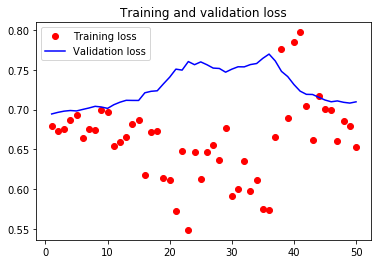

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

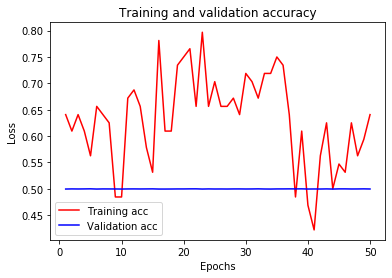

In [82]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [77]:

test_loss, test_acc = model.evaluate_generator(test_gen, steps=3)
print('test acc:', test_acc)
print("test_loss:", test_loss)

test acc: 0.47916666
test_loss: 0.7026702364285787
